# Datawhale 气象海洋预测-Task2 数据分析
数据分析是我们解决一个数据挖掘任务的重要一环，通过数据分析，我们可以了解标签的分布、数据中存在的缺失值和异常值、特征与标签之间的相关性、特征之间的相关性等，并根据数据分析的结果，指导我们后续的特征工程以及模型的选择和设计。

在本次任务中，我们将探索赛题中给出的两份训练数据，可视化分析四个气象特征的分布情况，思考如何进行特征工程以及如何选择或设计模型来实现我们的预测目标。

## 学习目标
1. 学习如何探索并可视化分析气象数据。
2. 根据数据分析结果思考以下两个问题：
    - 能否构造新的特征？如果可以，应该如何构造新的特征？
    - 选择或设计什么样的模型进行预测？

## 内容介绍
1. 以SODA数据集为例，探索标签的分布情况
    - 可视化总体数据中Nino3.4指数随时间的变化曲线
    - 可视化样本中Nino3.4指数随时间的变化曲线
2. 以SST特征为例，进行海陆掩膜和插值分析
    - 进行陆地掩膜，并对海洋部分的SST进行插值
    - 以样本0为例，可视化每个月海洋的SST分布情况
3. 以CMIP数据集为例，进行缺失值分析
    - 统计四个气象特征中缺失值的数量
    - 以Ua特征为例，可视化分析缺失值的情况
4. 温度场和风场可视化
    - 以样本0的第0月为例，可视化温度场和风场
5. 总结

## 代码示例

在本次任务中我们需要用到global_land_mask这个Python库，这个库可以根据输入的纬度和经度判断该点是否在陆地上。

安装global_land_mask

In [2]:
!pip install global_land_mask

     |████████████████████████████████| 1.8 MB 601 kB/s eta 0:00:01


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import netCDF4
import seaborn as sns
from global_land_mask import globe
from scipy import interpolate
plt.rcParams['font.sans-serif'] = ['SimHei'] #中文支持
%matplotlib inline

### 以SODA数据集为例，探索标签的分布情况

In [4]:
# 读取SODA数据

# 存放数据的路径
path = '/kaggle/input/ninoprediction/'
data = netCDF4.Dataset(path + 'SODA_train.nc')
label = netCDF4.Dataset(path + 'SODA_label.nc')
label = np.array(label.variables['nino'])

In [5]:
print(data.variables['sst'].shape)

(100, 36, 24, 72)


In [6]:
label.shape

(100, 36)

可以看到，数据集中的每个样本是以某一年为起始的接下来36个月的气象数据，同样的，标签也是以这一年为起始的接下来36个月中每个月的Nino3.4指数。然而一年只有12个月，怎么会有36个月的数据呢？

我们不妨来查看一下，将每个样本中的12个月进行拼接时，Nino3.4指数的变化曲线。

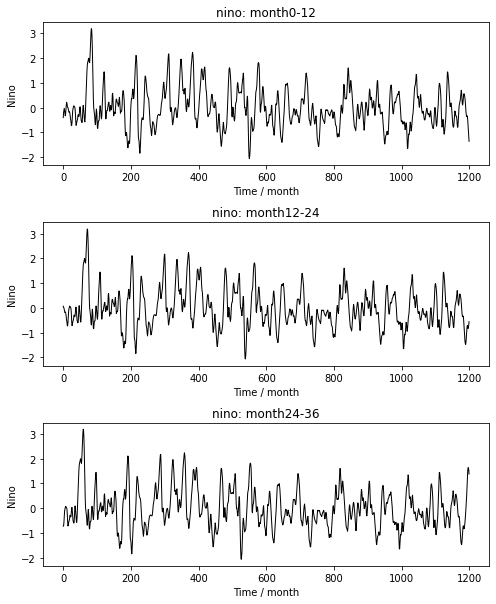

In [7]:
# 分别将样本中的0-12月、12-24月、24-36月进行拼接，绘制Nino3.4指数的变化曲线
plt.figure(figsize=(8, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(3):
    label_all = [label[j, 12*i:12*(i+1)] for j in range(label.shape[0])]
    label_all = np.concatenate(label_all, axis=0)
    plt.subplot(3, 1, i+1)
    plt.plot(label_all, 'k', linewidth=1)
    plt.xlabel('Time / month')
    plt.ylabel('Nino')
    plt.title('nino: month{}-{}'.format(12*i, 12*(i+1)))
plt.show()

从图中可以看出，三条曲线的变化趋势是完全相同的，只是在时间上有12个月的位移。这说明，重叠部分的标签是相同的，给出这样的样本的目的是可以以前12个月作为模型的输入X、后24个月为预测目标Y构建训练样本。

进一步思考，将每个样本构建一个训练样本，那么我们所能得到的训练数据量就只有4645（CMIP数据）+100（SODA数据）=4745条，这样小的数据量用于模型训练必然是不够的，那么如何增加数据量呢？这个问题留待大家思考。

同样的，我们可以随机抽取三个样本，查看每个样本中的Nino3.4指数变化曲线。

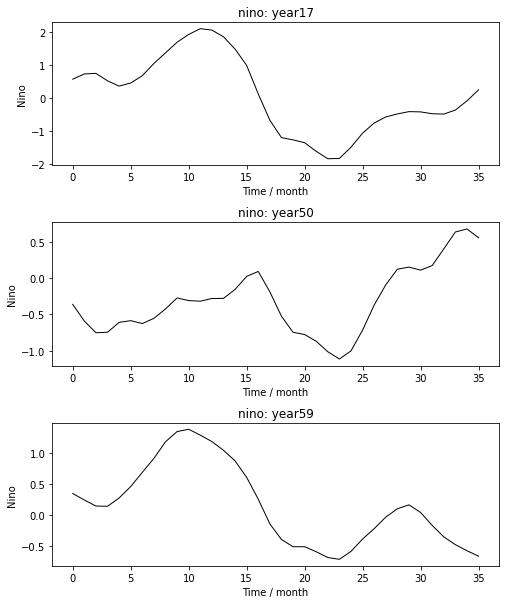

In [8]:
# 随机抽取三个样本，绘制Nino3.4指数变化曲线
plt.figure(figsize=(8, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(3):
    y = random.randint(0, label.shape[0])
    plt.subplot(3, 1, i+1)
    plt.plot(label[y], 'k', linewidth=1)
    plt.xlabel('Time / month')
    plt.ylabel('Nino')
    plt.title('nino: year{}'.format(y))
plt.show()

### 以SST特征为例，进行海陆掩膜和插值分析

在给定数据中，经度和纬度坐标都是离散的，每隔5度有一个坐标点，在这样的经纬度坐标下的SST值也是离散的，因此我们以样本0第0月的SST数据为例，用插值函数来拟合经纬度坐标与SST值之间的函数关系，得到平滑的SST分布。

In [9]:
lon = np.array(data.variables['lon'])
lat = np.array(data.variables['lat'])

In [10]:
x = lon
y = lat
# 以纬度和经度生成网格点坐标矩阵
xx, yy = np.meshgrid(x, y)
# 取样本0第0月的SST值
z = data.variables['sst'][0, 0]
# 采用三次多项式插值，得到z = f(x, y)的函数f
f = interpolate.interp2d(x, y, z, kind = 'cubic')

In [11]:
x

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
       165., 170., 175., 180., 185., 190., 195., 200., 205., 210., 215.,
       220., 225., 230., 235., 240., 245., 250., 255., 260., 265., 270.,
       275., 280., 285., 290., 295., 300., 305., 310., 315., 320., 325.,
       330., 335., 340., 345., 350., 355.])

经度的实际取值是从-180°到0°到180°，而给定的数据中经度的取值是0°到360度每间隔5°取一个坐标值，因此在之后判断是否为陆地时需要转换为实际的经度。

In [12]:
y

array([-55., -50., -45., -40., -35., -30., -25., -20., -15., -10.,  -5.,
         0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.])

数据中纬度的取值也是每间隔5°取一个坐标值。

判断每个经纬度坐标点是否在陆地上，用空值遮盖陆地部分，便于观察海洋上SST的分布。

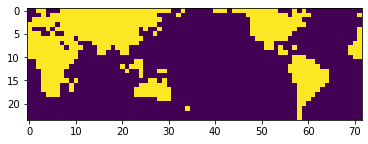

In [13]:
# 将经度x转换为实际经度重新生成网格点坐标矩阵
lon_grid, lat_grid = np.meshgrid(x-180, y)
# 判断坐标矩阵上的网格点是否为陆地
is_on_land = globe.is_land(lat_grid, lon_grid)
is_on_land = np.concatenate([is_on_land[:, x >= 180], is_on_land[:, x < 180]], axis=1)
# 进行陆地掩膜，将陆地的SST设为空值
z[is_on_land] = np.nan
# 可视化掩膜结果，黄色为陆地，紫色为海洋
plt.imshow(is_on_land[::-1, :])

In [14]:
z.shape

(24, 72)

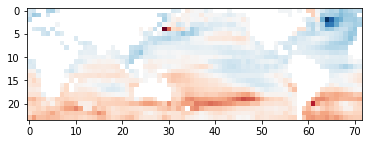

In [15]:
# 可视化海洋上的SST分布
plt.imshow(z[::-1, :], cmap=plt.cm.RdBu_r)

由上图可以看到，SST的分布是离散的，我们用之前得到的插值函数来平滑SST值，可视化平滑后的SST分布。

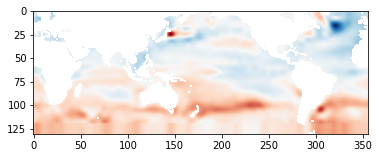

In [16]:
# 设置间隔为1°的经纬度坐标网格，用插值函数得到该坐标网格点的SST值
xnew = np.arange(0, 356, 1)
ynew = np.arange(-65, 66, 1)
znew = f(xnew, ynew)
lon_grid, lat_grid = np.meshgrid(xnew-180, ynew)
is_on_land = globe.is_land(lat_grid, lon_grid)
is_on_land = np.concatenate([is_on_land[:, xnew >= 180], is_on_land[:, xnew < 180]], axis=1)
# 同样进行陆地掩膜
znew[is_on_land] = np.nan
# 绘制平滑后的SST分布图
plt.imshow(znew[::-1, :], cmap=plt.cm.RdBu_r)

我们用同样的方法绘制样本0中每个月的SST分布图，观察SST分布的变化。

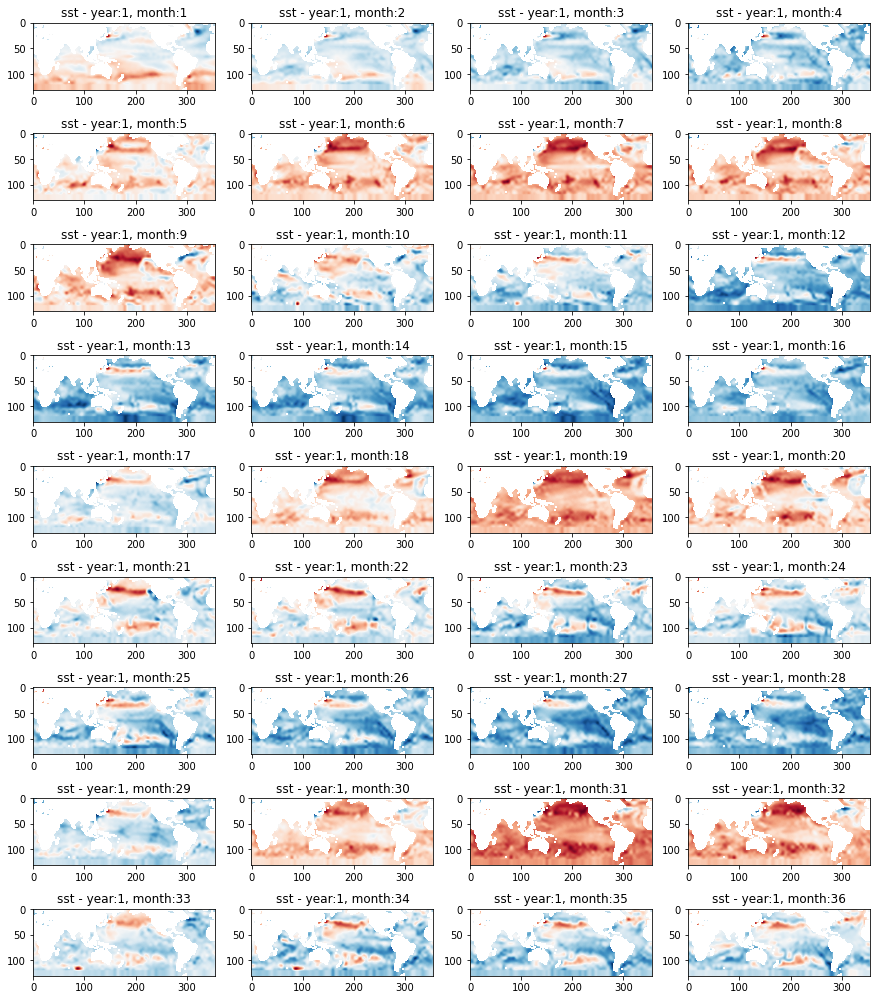

In [17]:
# 绘制0年36个月的海陆掩膜
for i in range(1):
    plt.figure(figsize=(15, 18))
    for j in range(36):
        x = lon
        y = lat
        xx, yy = np.meshgrid(x, y)
        z = data.variables['sst'][i, j]
        f = interpolate.interp2d(x, y, z, kind='cubic')
        
        xnew = np.arange(0, 356, 1)
        ynew = np.arange(-65, 66, 1)
        znew = f(xnew, ynew)
        
        lon_grid, lat_grid = np.meshgrid(xnew-180, ynew)
        is_on_land = globe.is_land(lat_grid, lon_grid)
        is_on_land = np.concatenate([is_on_land[:, xnew >= 180], is_on_land[:, xnew < 180]], axis=1)
        znew[is_on_land] = np.nan
        plt.subplot(9, 4, j+1)
        plt.imshow(znew[::-1, :], cmap=plt.cm.RdBu_r)
        plt.title('sst - year:{}, month:{}'.format(i+1, j+1))

可以看到，SST在每12个月中的前4个月和后4个月都较低，在中间4个月时较高，这说明，海表温度在春季和冬季较低，在夏季和秋季呈现逐渐升高到最高点然后逐渐降低的变化趋势，这与我们的认知常识是相符的。

大家也可以用同样的方法观察分析其它三个气象特征的变化趋势。

### 以CMIP数据集为例，进行缺失值分析

In [18]:
# 读取CMIP数据

# 存放数据的路径
path = '/kaggle/input/ninoprediction/'
data = netCDF4.Dataset(path + 'CMIP_train.nc')
label = netCDF4.Dataset(path + 'CMIP_label.nc')
label = np.array(label.variables['nino'])

In [19]:
# 获得陆地的掩膜
lon_grid, lat_grid = np.meshgrid(x-180, y)
is_on_land = globe.is_land(lat_grid, lon_grid)
is_on_land = np.concatenate([is_on_land[:, x >= 180], is_on_land[:, x < 180]], axis=1)
mask = np.zeros(data.variables['sst'].shape, dtype=int)
mask[:, :, :, :] = is_on_land[np.newaxis, np.newaxis, :, :]

In [20]:
# 查看SST特征的缺失值数量
name = 'sst'
data_ = np.array(data.variables[name])
before_nan = np.sum(np.isnan(data_))
print('before:', before_nan)

before: 0


In [21]:
# 查看T300特征的缺失值数量
name = 't300'
data_ = np.array(data.variables[name])
before_nan = np.sum(np.isnan(data_))
print('before:', before_nan)

before: 3055032


In [22]:
# 查看Va特征的缺失值数量
name = 'va'
data_ = np.array(data.variables[name])
before_nan = np.sum(np.isnan(data_))
print('before:', before_nan)

before: 13921123


In [23]:
# 查看Ua特征的缺失值数量
name = 'ua'
data_ = np.array(data.variables[name])
before_nan = np.sum(np.isnan(data_))
print('before:', before_nan)

before: 13921123


四个气象特征中，SST特征不存在缺失值，Va和Ua特征中的缺失值数量最多。

接下来以Ua特征为例，可视化分析缺失值的情况。

In [24]:
# 统计每年每月中Ua特征的缺失值数量
m = np.zeros(data_.shape[0:2])
for i in range(data_.shape[0]):
    for j in range(data_.shape[1]):
        if np.sum(np.isnan(data_[i][j])) != 0:
            m[i, j] = np.sum(np.isnan(data_[i, j]))

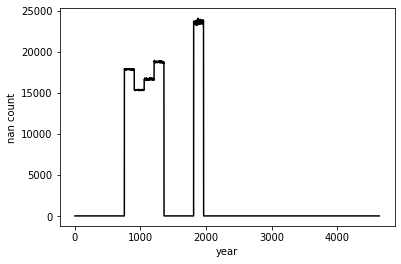

In [25]:
# 计算每一年的缺失值
before = np.sum(m, axis=1)
# 可视化每一年的缺失值数量
plt.plot(before, 'k')
plt.ylabel('nan count')
plt.xlabel('year')
plt.show()

可以看到在某些年份中存在较多缺失值。

In [26]:
# 查看Ua特征中存在缺失值的年数
len(np.where(before!=0)[0])

755

我们取样本1900来观察Ua特征的分布。

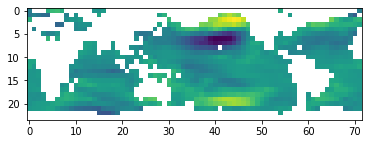

In [27]:
# 可视化样本1900中Ua特征的分布
plt.imshow(data_[1900, 0][::-1, :])

上图中白色部分即为缺失值，可以看到，缺失值多数分布在陆地上，我们将陆地部分进行填充，观察填充后Ua的分布。

In [28]:
# 将陆地位置填0
data_[mask==1] = 0

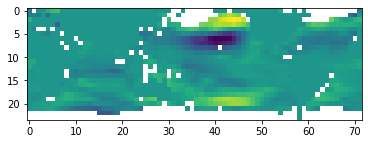

In [29]:
# 可视化填充后样本1900中Ua特征的分布
plt.imshow(data_[1900, 0][::-1, :])

对陆地部分进行填充后缺失值数量大大减少。

In [30]:
# 统计填充后缺失值的数量
after_nan = np.sum(np.isnan(data_))

In [31]:
print('before: %d \nafter: %d \npercentage: %f'%(before_nan, after_nan, 1 - float(after_nan) / before_nan))

before: 13921123 
after: 2440742 
percentage: 0.824673


陆地部分填充处理了82%的缺失值。

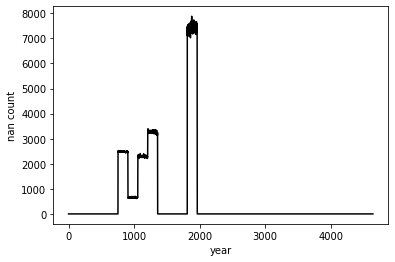

In [32]:
# 可视化填充后每一年的缺失值数量
m = np.zeros(data_.shape[0: 2])
for i in range(data_.shape[0]):
    for j in range(data_.shape[1]):
        if np.sum(np.isnan(data_[i, j])) != 0:
            m[i, j] = np.sum(np.isnan(data_[i, j]))
after = np.sum(m, axis=1)
plt.plot(after, 'k')
plt.ylabel('nan count')
plt.xlabel('year')
plt.show()

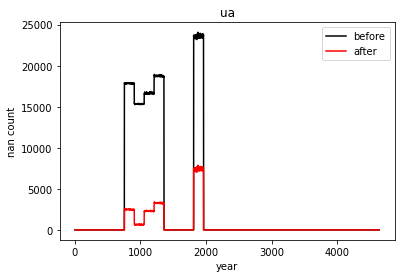

In [33]:
# 对比填充前后每一年缺失值的数量
plt.plot(before, 'k')
plt.plot(after, 'r')
plt.legend(['before', 'after'])
plt.title(name)
plt.ylabel('nan count')
plt.xlabel('year')
plt.show()

### 温度场和风场可视化

在气候问题中，温度与风向往往是密切相关的。当温度越高时，气压越低，空气向上流动，温度越低时，气压越高，空气向下流动，于是温度高的地方上方的空气就会向温度低的地方流动，形成风。因此在分析气候问题时，我们往往会把温度和风向放在一起进行可视化。

如何把风向可视化呢？这里我们要用到plt.quiver()这个函数。

plt.quiver()用于绘制二维的向量场，主要输入参数有：

- X：向量起始点的X轴坐标
- Y：向量起始点的Y轴坐标
- U：向量的X轴分量
- V：向量的Y轴分量

详细的用法可以参考官网：https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html

In [34]:
# 对温度场SST进行插值，得到插值函数
x = lon
y = lat
xx, yy = np.meshgrid(x, y)
z = data.variables['sst'][0, 0]
f = interpolate.interp2d(x, y, z, kind='cubic')

In [35]:
# 获得陆地掩膜
lon_grid, lat_grid = np.meshgrid(x-180, y)
is_on_land = globe.is_land(lat_grid, lon_grid)
is_on_land = np.concatenate([is_on_land[:,x>=180], is_on_land[:,x<180]], axis=1)

# 对Ua和Va进行陆地掩膜
ua = data.variables['ua'][0, 0]
ua[is_on_land] = np.nan
va = data.variables['va'][0, 0]
va[is_on_land] = np.nan

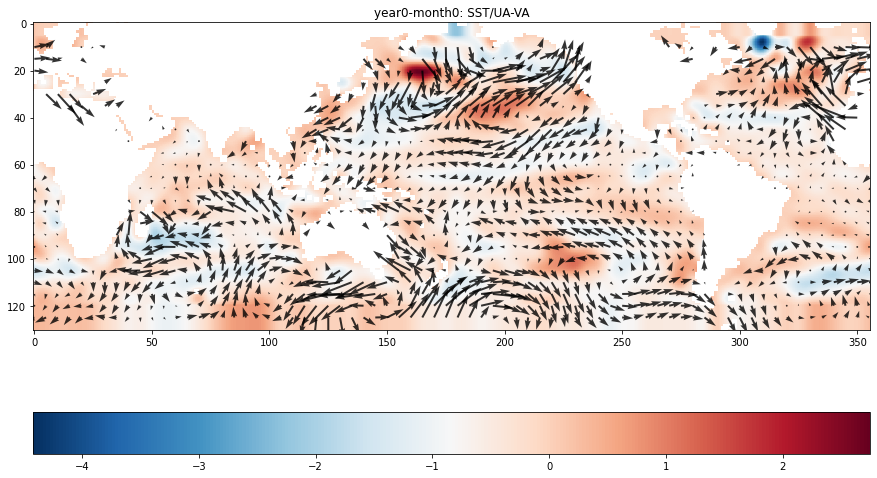

In [36]:
# 插值后生成平滑的SST分布
xnew = np.arange(0, 356, 1)
ynew = np.arange(-65, 66, 1)
znew = f(xnew, ynew)

# 对平滑后的SST进行陆地掩膜
lon_grid, lat_grid = np.meshgrid(xnew-180, ynew)
is_on_land = globe.is_land(lat_grid, lon_grid)
is_on_land = np.concatenate([is_on_land[:, xnew >= 180], is_on_land[:, xnew < 180]], axis=1)
znew[is_on_land] = np.nan

# 绘制温度场
plt.figure(figsize=(15, 10))
plt.imshow(znew[::-1, :], cmap=plt.cm.RdBu_r)
plt.colorbar(orientation='horizontal') # 显示水平颜色条
# 绘制风向场，其实这里准确来说绘制的是风向异常的向量，而非实际的风向
plt.quiver(lon, lat+65, ua[::-1, :], va[::-1, :], alpha=0.8) # 在坐标(lon, lat)处绘制与sqrt(ua^2, va^2)成正比长度的箭头
plt.title('year0-month0: SST/UA-VA')
plt.show()

从上图中可以看出，温度异常SST在0值附近时没有明显的风向异常，而在其他区域风向异常通常由SST值大的地方指向SST值小的地方。

ENSO现象是指在温度场上赤道东太平洋温度持续异常增暖，在风向场上热带东太平洋与热带西太平洋气压变化（表现为风向）相反的现象。在上图这个样本中没有出现ENSO现象，大家可以用同样的方法绘制并观察存在ENSO现象（Nino3.4指数连续5个月超过0.5℃）的样本的温度和风场。

## 总结

在以上的数据分析中，不难看出我们在分析气象问题时，采用的仍然是通用的数据分析思路：分析标签 -> 分析特征（包括特征分布、特征与特征的关系、特征与标签的关系） -> 分析数据的基本情况（包括缺失值、异常值、重复值等）。这个思路大家可以灵活应用到各种问题的分析中去，不至于拿到数据后无从下手。

通过以上的数据分析，我们可以得到以下结论：

1. 重叠部分的标签是相同的，为了增加数据量，我们可以从每条数据中取固定的12个月拼接起来，用滑窗构建训练数据集。
2. SST特征中没有缺失值，在其他特征中，缺失值基本上在陆地部分，将陆地部分用0填充可以解决绝大部分的缺失值。

细心的同学会发现，在上述的结论中没有提到SST分布、温度和风场可视化等我们在前面做的一些分析结果。原因是在实际的竞赛过程中，这些分析并没有对后续的特征工程或模型构造起到指导作用，再深究其根本原因，是我们并不能从这些分析中找到构造新的特征的思路，这就回答了我们开篇提出的第一个思考问题——能否构造新的特征，目前的答案是不能。

从目前各位TOP选手的思路以及相关的ENSO预测的论文来看，大家的目光都聚焦在如何构建模型上，而跳过了构造特征这个步骤。我认为原因在于给出的这四个特征已经是从气象问题中抽取出来的相互独立的特征，已经是高度凝练、与预测目标具有高度相关性的特征，不必要也很难从特征之间的关联性入手构造新的特征。更有意思的事情是，在竞赛过程中我们发现，单纯使用SST特征比使用所有的四个特征有更好的效果，因为Nino3.4指数的定义就是从当月开始连续5个月的SST的滑动平均值。

那么我们为什么仍然要做这些数据分析呢？其一是为了对数据、对问题背景加深了解；其二是希望大家不要局限于本赛题，能够把这些分析方法迁移到其他时空数据的分析中去。

## 作业

现在，问题已经很明确了，我们要实现的目标是构造一个模型来充分挖掘时间和空间信息，同时由于数据量小，再构建模型时要充分考虑到如何降低过拟合风险。在学习TOP选手的方案之前，请尝试思考你会如何构造模型。

## 参考文献

1. https://gitee.com/Little_Six/aiweather-ocean-forecasts/blob/master/code/EDA.ipynb?spm=5176.21852664.0.0.4aab7f46PqZUih&file=EDA.ipynb
2. https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni
3. https://cmdp.ncc-cma.net/pred/cn_enso.php?product=cn_enso_nino_indices